## Importing the libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

sns.set()

## Reading the dataset

In [19]:
# Reading the charging dataset
charging_df = pd.read_csv("datasets/ev-charging-stations-india.csv")
charging_df.head()

,name,state,city,address,lattitude,longitude,type
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.6019,76.9803,12.0
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.4673,77.0818,12.0
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.8751,76.2760,12.0
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.3105,77.7218,12.0
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.3105,77.7218,12.0


In [20]:
charging_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1547 non-null   object 
 1   state      1547 non-null   object 
 2   city       1547 non-null   object 
 3   address    1507 non-null   object 
 4   lattitude  1541 non-null   object 
 5   longitude  1541 non-null   float64
 6   type       1539 non-null   float64
dtypes: float64(2), object(5)
memory usage: 84.7+ KB


## Data Preprocessing

### Dropping Duplicate Data

In [21]:
# Drop duplicate values
print(f"Number of duplicate rows: {charging_df.duplicated().sum()}")
charging_df.drop_duplicates(inplace=True)

Number of duplicate rows: 205


### Dropping Missing Data

In [22]:
# Drop missing values
charging_df.dropna(inplace=True)
charging_df.reset_index(drop=True, inplace=True)

### Changing dtype of variables

In [23]:
# Changing the datatype of variables
charging_df["lattitude"] = charging_df["lattitude"].str.replace(',', '').astype(float)
charging_df["type"] = charging_df["type"].astype(int)

### Creating new variable `charging_speed`

In [24]:
# Creating a variable "charging_speed"
def encode_type(type_value):
    if type_value <= 11:
        return "slow"
    elif type_value <= 16:
        return "fast"
    else:
        return "ultra-fast"

charging_df["charging_speed"] = charging_df["type"].apply(encode_type)

### Cleaning the `lattitude` and `longitude` variables

In [25]:
charging_df.describe()

,lattitude,longitude,type
count,1291.000000,1.291000e+03,1291.000000
mean,19.907463,6.599958e+04,8.928737
std,6.932307,2.368613e+06,4.167747
min,8.390198,8.058454e+00,6.000000
25%,13.032111,7.578536e+01,7.000000
50%,19.051601,7.721756e+01,7.000000
75%,27.179942,7.846415e+01,10.000000
max,77.597289,8.510551e+07,24.000000


The maximum value for the `longitude` variable is 85105514 and minimum value is 8.0584541 which could be a mistake. Also the maximum value for the `lattitude` variable is 77.597289. As the longitude of India ranges from approximately 68 to 97, and lattitude ranges from 8 to 37, we will correct these values in the below cells.

In [26]:
# Correcting the maximum and minimum values of the longitude variable
charging_df.iloc[charging_df.longitude.argmax(), 5] = charging_df.iloc[charging_df.longitude.argmax(), 5] / 10e5
charging_df.iloc[charging_df.longitude.argmin(), 5] = charging_df.iloc[charging_df.longitude.argmin(), 5] * 10

In [27]:
index = charging_df.lattitude.argmax()
lat = charging_df.loc[charging_df.lattitude.argmax(), "lattitude"]

# Swap the values of latitude and longitude for row 535
charging_df.loc[index, "lattitude"] = charging_df.loc[index, "longitude"]
charging_df.loc[index, "longitude"] = lat

In [28]:
charging_df.describe()

,lattitude,longitude,type
count,1291.000000,1291.000000,1291.000000
mean,19.857340,77.586028,8.928737
std,6.746304,3.663208,4.167747
min,8.390198,69.678673,6.000000
25%,13.031820,75.794858,7.000000
50%,19.051601,77.217962,7.000000
75%,27.094893,78.466949,10.000000
max,32.991800,94.168072,24.000000


### Correcting the state names

In [29]:
incorrect_state_name = {
    "Uttrakhand": "Uttarakhand",
    "Uttarkhand": "Uttarakhand",
    "Tamilnadu": "Tamil Nadu",
    "Taminadu": "Tamil Nadu",
    "Westbengal": "West Bengal",
    "Hyderabadu00A0": "Hyderabad",
    "Jammu": "Jammu & Kashmir",
    "Andhra pradesh": "Andhra Pradesh",
    "Andra Pradesh": "Andhra Pradesh",
    "Andhrapradesh": "Andhra Pradesh",
    "Rajahmundry": "Andhra Pradesh",
    "Puducherry": "Pondicherry",
    "Bhubhaneswar": "Odisha",
    "Chattisgarh": "Chhattisgarh",
    "Chikhali": "Maharashtra",
    "Maharashra": "Maharashtra",
    "Delhi Ncr": "Delhi",
    "Ernakulam": "Kerala",
    "Karala": "Kerala",
    "Kochi": "Kerala",
    "Hisar": "Haryana",
    "Harayana": "Haryana",
    "Jajpur": "Rajasthan",
    "Limbdi": "Gujarat",
    "Andaman": "Andaman & Nicobar",
}

charging_df["state"] = charging_df["state"].str.strip().str.title()
charging_df["state"] = charging_df["state"].replace(incorrect_state_name)
charging_df["state"] = charging_df["state"].str.strip().str.title()


### Correcting the city names

In [31]:
incorrect_city_name = {
    "Delhi": "New Delhi",
    "Bengaluru": "Bangalore"
}

charging_df["city"] = charging_df["city"].str.strip().str.title()
charging_df["city"] = charging_df["city"].replace(incorrect_city_name)

## EDA

### Top 10 states with maximum charging stations

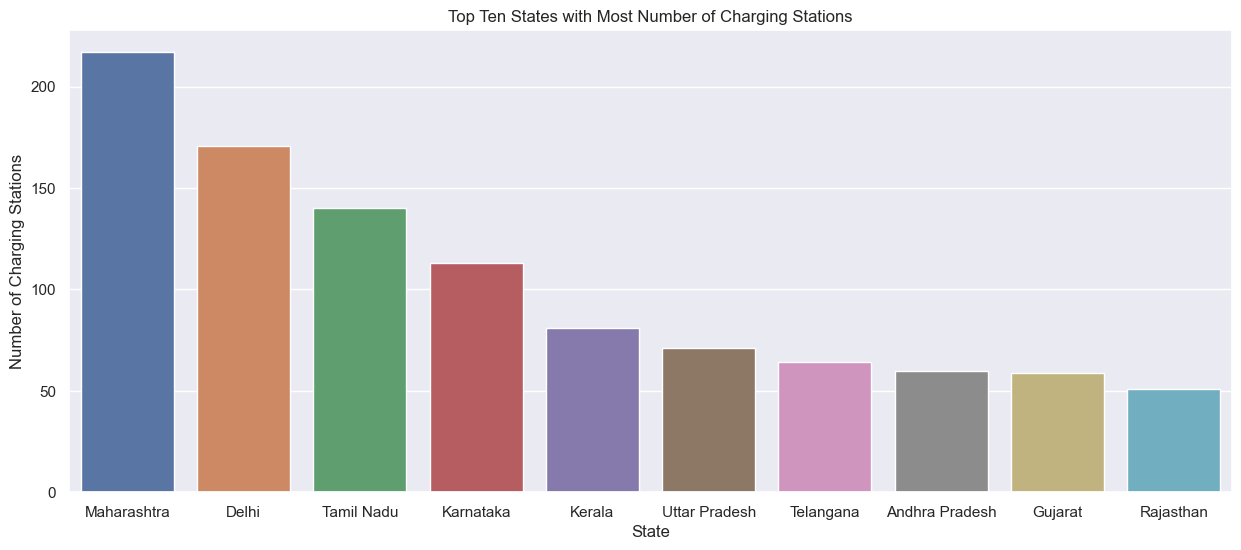

In [33]:
# Get the top ten states with most number of charging stations.
top_ten_states = charging_df["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states["index"], y=top_ten_states["state"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Most Number of Charging Stations")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations");

The plot shows the distribution of charging stations in India by state. The state with the most number of charging stations is `Maharashtra`, followed by `Delhi` and `Tamil Nadu`.

### Top 10 cities with maximum charging stations

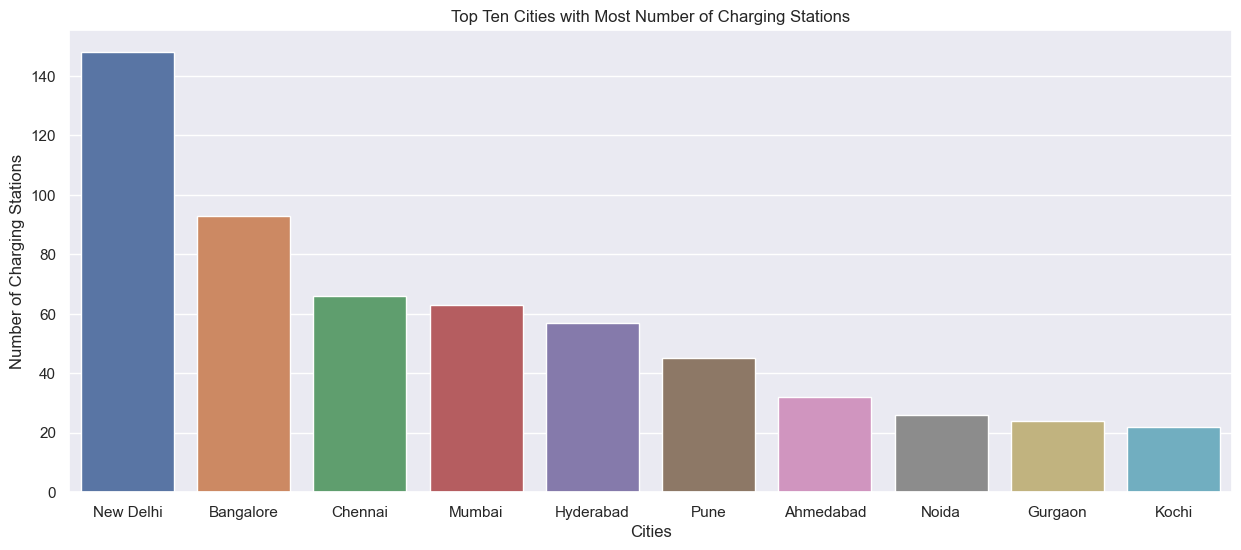

In [34]:
# Get the top ten cities with most number of charging stations.
top_ten_city = charging_df["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_city["index"], y=top_ten_city["city"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Most Number of Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

The plot shows the distribution of charging stations in India by city. The city with the most number of charging stations is `New Delhi`, followed by `Bangalore` and `Chennai`. We can see that the top 4 cities are metropolitan cities.

### Distribution of different types of charging stations

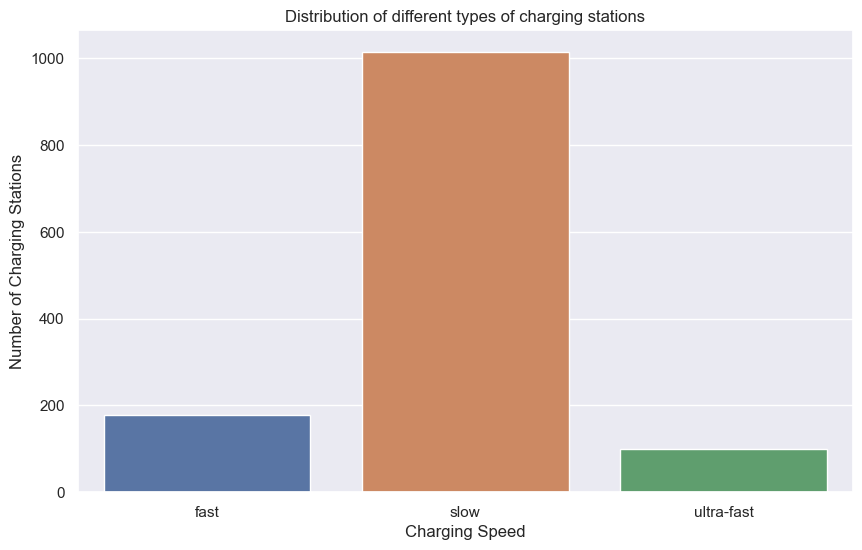

In [37]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.countplot(data=charging_df, x="charging_speed")

# Add a title and labels to the axes.
plt.title("Distribution of different types of charging stations")
plt.xlabel("Charging Speed")
plt.ylabel("Number of Charging Stations");

Most of the charging stations in India provide slow charging for the EV. There are very few ultra-fast charging stations.

### States with fast charging stations

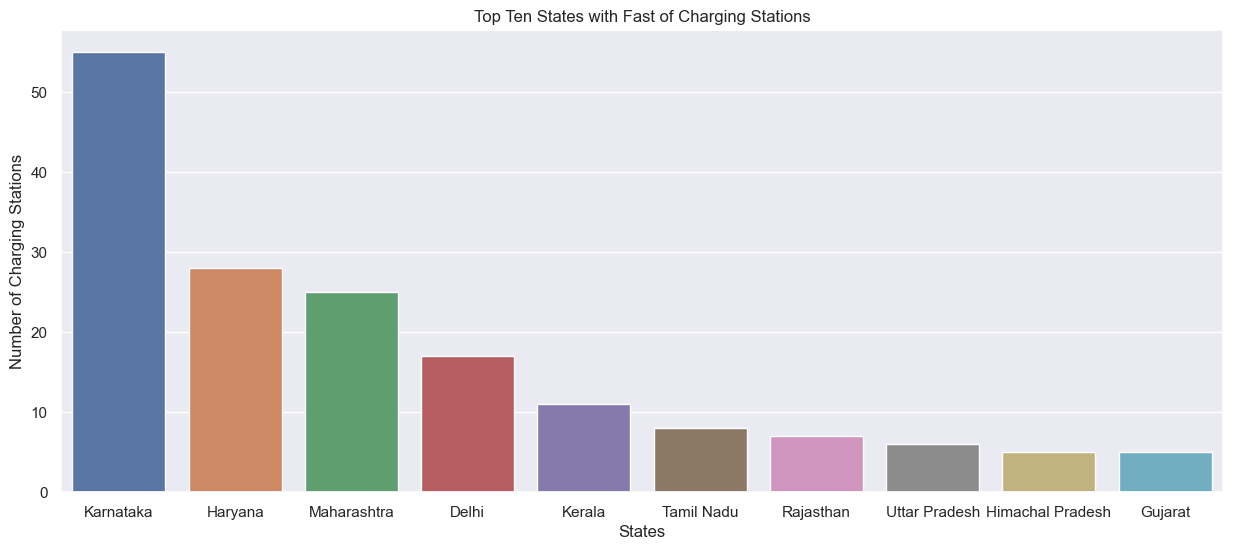

In [45]:
fast_charging = charging_df.query("charging_speed == 'fast'")
top_ten_states_fast = fast_charging["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states_fast["index"], y=top_ten_states_fast["state"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Fast of Charging Stations")
plt.xlabel("States")
plt.ylabel("Number of Charging Stations");

`Karnataka` has the highest number of fast charging stations.

### Cities with fast charging stations

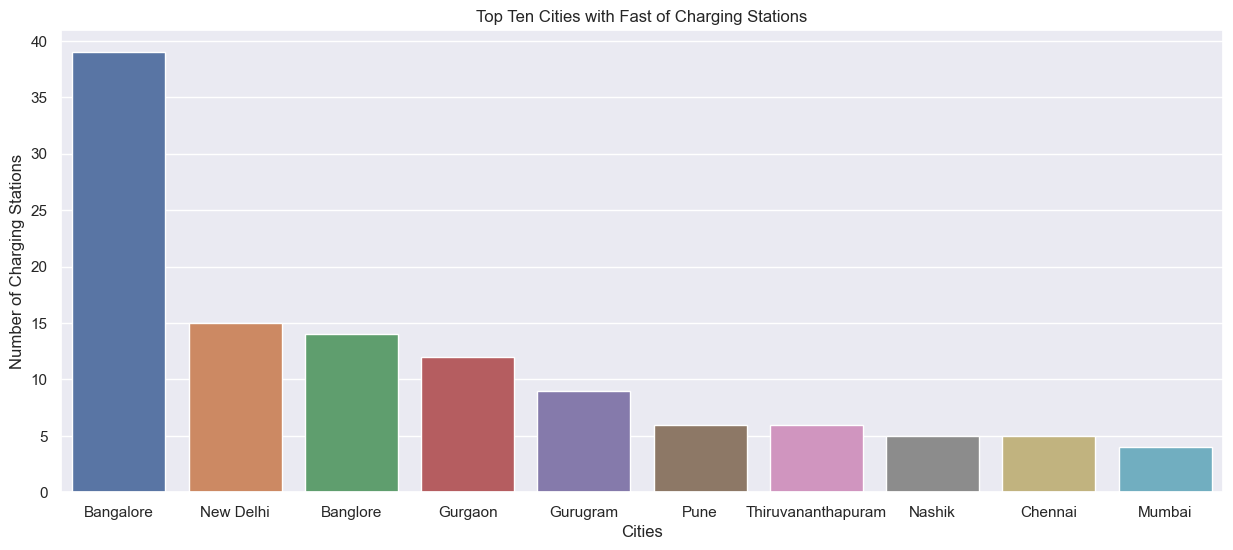

In [49]:
top_ten_cities_fast = fast_charging["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_cities_fast["index"], y=top_ten_cities_fast["city"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Fast of Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

`Bangalore` has the highest number of fast charging stations.

### States with ultra-fast charging stations

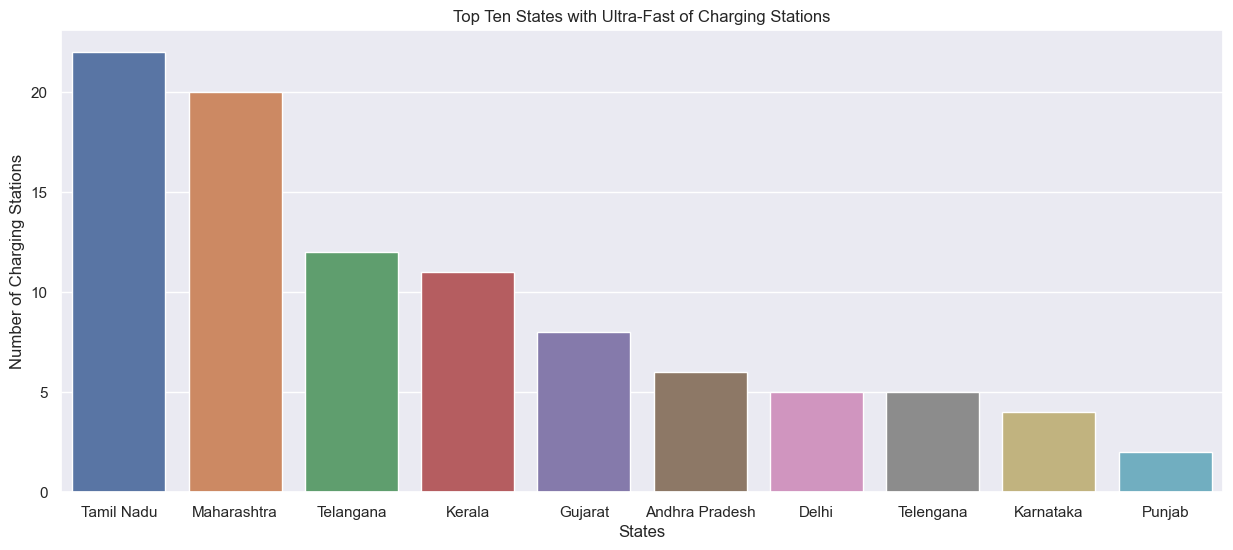

In [50]:
ultra_fast_charging = charging_df.query("charging_speed == 'ultra-fast'")
top_ten_states_ultra_fast = ultra_fast_charging["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states_ultra_fast["index"], y=top_ten_states_ultra_fast["state"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Ultra-Fast of Charging Stations")
plt.xlabel("States")
plt.ylabel("Number of Charging Stations");

`Tamil Nadu` and `Maharashtra` has the highest number of ultra-fast charging stations.

### Cities with ultra-fast charging stations

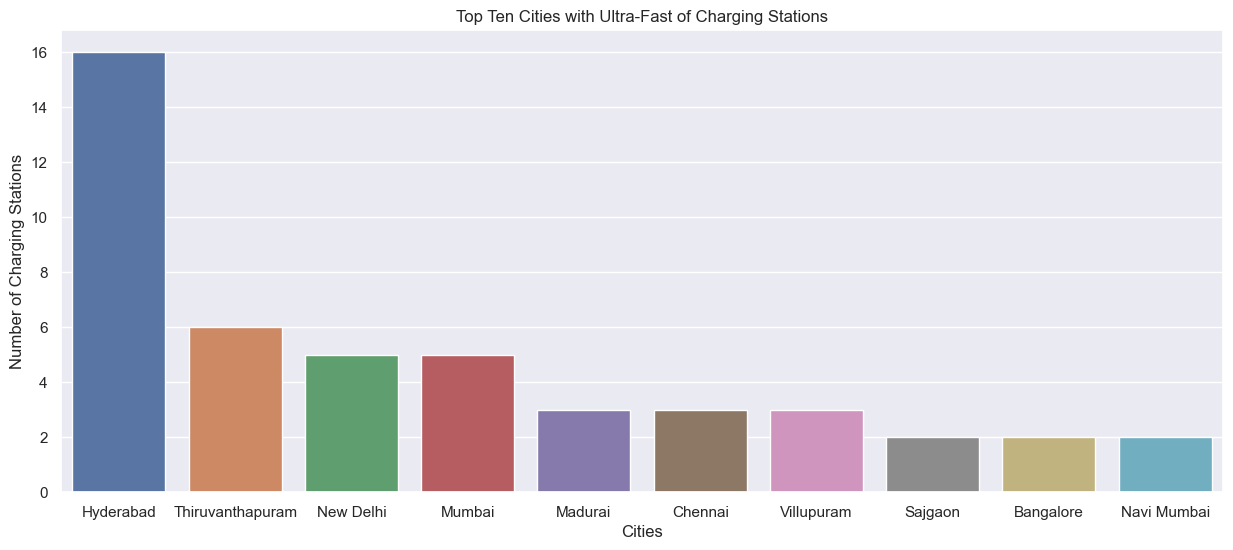

In [51]:
top_ten_cities_ultra_fast = ultra_fast_charging["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_cities_ultra_fast["index"], y=top_ten_cities_ultra_fast["city"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Ultra-Fast of Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

`Hyderabad` has the highest number of ultra-fast charging stations.